# Catmon Image Classifier Iteration1 vgg16

This notebook is based on Pluralsight FixedFeatureExtractor vgg16.ipynb

Uses pre-trained VGG16 model.

---

Limitations:
- iteration 1 uses only 192 images of boo and 192 images of simba, split evenly between train, val and test (64 images each).
- basic transformation

**5 epochs on cpu shows model test accuracy of 100% (!)**

## Set-up

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms
from torchvision import models

from IPython.display import Image
from PIL import Image

In [27]:
# TD: use GPU if available

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Prepare data

\# TD: all pretrained models in pytorch have certain requirements:
Ref: https://pytorch.org/vision/stable/models.html
- image size must be at least 224x224 pixels
- scaled to (0, 1)
- normalised with mean and std dev values given below:

In [29]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [30]:
# TD: apply series of transformations, including:
# - those given above 
# - random flipping
# - convert to tensor
# = note that normalisation happens after conversion to tensor

In [31]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [32]:
# TD: apply transformation to validation and test
# = note: resize and centre crop to get 224x224

In [33]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

Use small sample of catmon images of boo and simba (192 of each), split into train (64), val (64) and test (64)

In [34]:
train_dir = 'datasets/catmon/train'
val_dir = 'datasets/catmon/val'
test_dir = 'datasets/catmon/test'

batch_size = 8
num_workers = 4

\# TD: note that the ImageNet dataset has many images of different breeds of cats and dogs
- labels: 151-290
- see list of Imagenet categories here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

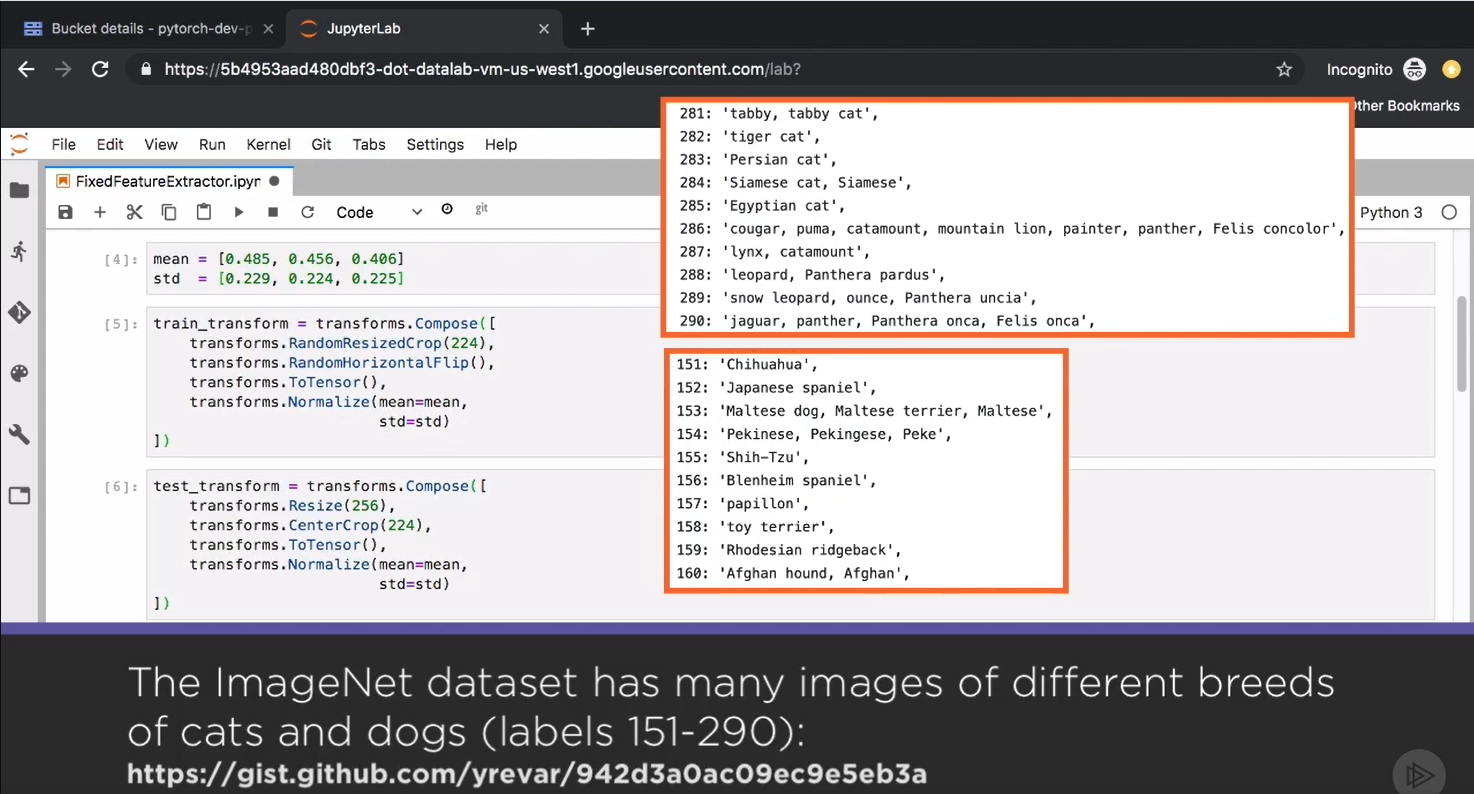

In [2]:
from PIL import Image
Image.open("images/ImageNet categories, re dogs and cats.jpg")

In [36]:
# TD: create dataset that points to training folder
# - expect 192 datapoints: 64 boo, 64 simba, 64 unknown 

In [37]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

In [38]:
train_data

Dataset ImageFolder
    Number of datapoints: 192
    Root location: datasets/catmon/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [39]:
# TD: define data loader for training dataset
# - note that this uses batch size defined earlier and is shuffled

In [40]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=num_workers)

In [41]:
# TD: and set-up validation dataset

In [42]:
val_data = datasets.ImageFolder(root=val_dir,
                                 transform=test_transform)

In [43]:
val_data 

Dataset ImageFolder
    Number of datapoints: 192
    Root location: datasets/catmon/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [44]:
# TD: define the validation loader
# - note that this uses batch size defined earlier and is shuffled

In [45]:
val_loader = torch.utils.data.DataLoader(val_data, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=num_workers)

In [46]:
# TD: and set-up test dataset

In [47]:
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

In [48]:
test_data 

Dataset ImageFolder
    Number of datapoints: 192
    Root location: datasets/catmon/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [49]:
# TD: define the test loader
# - note that this uses batch size defined earlier and is shuffled

In [50]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=num_workers)

In [67]:
# TD: define a dict with train, val and test dataloaders

In [68]:
dataloaders = {
    'train': train_loader,
    'val': test_loader,
    'test': test_loader
}

In [53]:
# TD: define a dict with train, val and test batch sizes

In [54]:
total_batch_sizes = {'train': len(train_loader), 'val': len(val_loader) , 'test': len(test_loader) }

In [55]:
total_batch_sizes

{'train': 24, 'val': 24, 'test': 24}

In [56]:
# Show the class names (categories)
# - expect 3: boo, simba and unknown

In [57]:
class_names = train_data.classes

print(class_names)

['boo', 'simba', 'unknown']


In [58]:
# TD: define helper function for displaying an image using matplotlib
# - convert image to numpy format (h, w, number of channels)
# - rescale by multiplying by std dev and adding mean
# - clip to range 0 to 1
# - pause after display

In [59]:
def imshow(inp, title):

    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))
    
    plt.imshow(inp)
    plt.title(title)
    plt.pause(3)

In [60]:
# TD: Show a few training images using torch makegrid utility func
# - expect sample of boo, simba and unknown (usually a dark image)

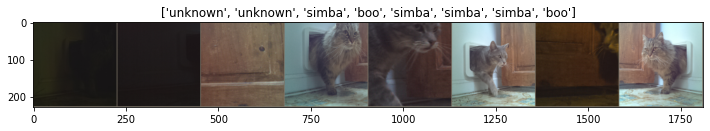

In [61]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

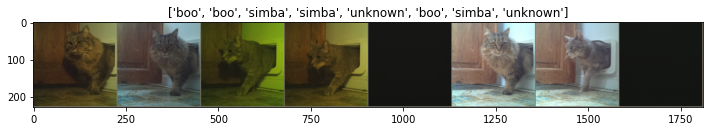

In [62]:
# TD: Show a few validatiion images using torch makegrid utility func
inputs, classes = next(iter(dataloaders['val']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

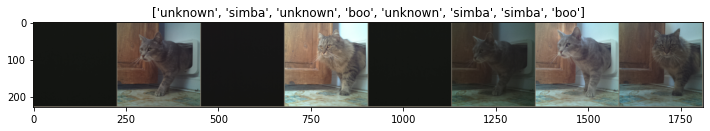

In [63]:
# TD: Show a few test images using torch makegrid utility func
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Define model

In [49]:
# TD: intantiate VGG16 pre-trained model 

In [51]:
# TD: set pre-trained=True as images are similar
# i.e. use pre-trained weights (model params)
# - reuse model arch and weights

In [52]:
model = models.vgg16(pretrained=True)

\# TD: show the model
- feature extractors are in early phase of the model
- these will be frozen

- at end you see classifier layer

Note that each part of the model is accessible via a key
- the final classifier layer has key 'classifier'
>(classifier): Sequential(...
- the linear layer is layer 6
> (6): Linear(in_features=4096, out_features=1000, bias=True)...

Can see input features to linear layer is 4096 and output is 1000 - we will chaneg 1000 to 2.

In [53]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [54]:
# TD: extract number of input and output features from the model

In [55]:
num_ftrs = model.classifier[6].in_features
num_ftrs

4096

In [56]:
model.classifier[6].out_features

1000

In [57]:
# TD: freeze the pre-trained model weights 
# - set requires_grad to false
# -> when we make a backward pass the model params will not be changes as no gradients will be calculated

In [58]:
for param in model.parameters():
    param.requires_grad = False

In [61]:
# TD: Now change last linear layer of the model
# - this is the only layer with requires_grad = True, the default
# - when we change the model, this is the only layer for which gradients will be calculated
# - change number of output categories to 3 (corresponding to our 3 catagories)
# - note that number of input features is unchanged (at 4096)

In [62]:
model.classifier[6] = nn.Linear(num_ftrs, 3)

\# TD: Check linear layer of model has been modified
> (6): Linear(in_features=4096, out_features=3, bias=True)

In [63]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Train model

In [64]:
# TD: Now ready to train our model
# set the training hyperparameters:

# - we have a linear layer so use crossEntropyLoss 
# - use SGD optimiser with lr=0.01, momentim=0.9

# - define a learning rate scheduler
# -- decays the learning rate of teh model params by gamma every step_size epochs
# -- learning rate decays by 0.1 every 7 epochs

In [65]:
criterion        = nn.CrossEntropyLoss()

optimizer_ft     = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

\# TD: define a helper func to train final layer, note:
- model is copied to device (in case we have cuda)

- define best_acc and best_model_wts to record best accuracy and corresponding model weights
 - these are a deep copy of the current model params from state dict

- run training for each epoch (1 pass through training data)
 - print current epoch and related info
 - after every epoch evaluate the data: iterate over train phase and then test phase
  - in training phase switch to train mode and call scheduler.step to update training params
  - in test phase switch to eval mode where batch normalisation and droput layers will be disabled
  - keep track of running loss and number of test predictions
  
  - load data from training or test (for appropriate phase), read data in batches
   - copy images and labels to device
   - zero out gradients of optimiser so that fresh grads will be calculated (only for linear layer) in backward pass 
    - update gradients for training phase only
      - make forward pass through model: run model on inputs, get predictions and calculate model loss (using criterion) on the output
      - if training then make backward pass through NN and update model params using gradients calculated
      - keep track of running loss of model and running correct predictions (actual=predicted)
      
 - calculate epoch accuracy for training and test
 - for test phase: determine if best model; if yes then save
 
- after training complete, show best and load model for best weights

In [66]:
# TD: add progress marker for each batch

In [67]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    model = model.to(device)
    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            
            if phase == 'train':
                #TD: call to scheduler moved to after call to optimiser following warning from pytorch 
#                 scheduler.step() 
                model.train()  
                
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                
                #TD: show more granular progress per batch
                print('.', end='')
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / total_batch_sizes[phase]
            epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)

            print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
                           
            if phase == 'train':
                #TD: call to scheduler moved to after call to optimiser following warning from pytorch 
                scheduler.step()
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    print('\nTraining complete')

    print('Best Validation Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model

In [68]:
# TD: run model for 5 epochs (note that is set to 1 on cpu)
# - as we are only training later layers of model then should only need a few epochs
# - and minimised cloud VM bill!

# Janani's original run for cats and dogs dataset with 5 epochs on GPU showed best test accuracy of ~98%
# TD accuracy on 1 epoch on CPU showed accuracy of ~95% (with Wall time: 16min 1s)
# TD accuracy on 5 epochs on GPU showed accuracy of ~98.6% (with Wall time: 4min 5s)
# TD accuracy on 10 epochs on GPU showed accuracy of ~98.3% (with Wall time: 8min 6s)

# TD's run (Pluralsight FixedFeatureExtractor vgg16.ipynb) for cats and dogs dataset:
# TD accuracy on 1 epoch on CPU showed accuracy of ~97% (with Wall time: 10min 13s)

# TD's run for boo and simba dataset
# TD accuracy on 1 epoch on CPU showed accuracy of ~99% (with Wall time: 1min 28s)
# TD accuracy on 1 epoch on CPU showed accuracy of ~100% (with Wall time: 5min 45s)

In [69]:
%%time
# model = train_model(model, criterion, optimizer_ft,
#                     exp_lr_scheduler, num_epochs=1)
model = train_model(model, criterion, optimizer_ft,
                    exp_lr_scheduler, num_epochs=5)


Epoch 0/4
----------
........................
train Loss: 5.2159 Acc: 0.8229
........................
val Loss: 0.0955 Acc: 0.9896

Epoch 1/4
----------
........................
train Loss: 3.5120 Acc: 0.9323
........................
val Loss: 1.7117 Acc: 0.9583

Epoch 2/4
----------
........................
train Loss: 5.3230 Acc: 0.9062
........................
val Loss: 0.0141 Acc: 1.0000

Epoch 3/4
----------
........................
train Loss: 6.7667 Acc: 0.8958
........................
val Loss: 0.2127 Acc: 0.9948

Epoch 4/4
----------
........................
train Loss: 10.7676 Acc: 0.8958
........................
val Loss: 0.0005 Acc: 1.0000

Training complete
Best Validation Acc: 1.000000
Wall time: 13min 33s


## Test model

\# TD: now let's use the model for predictions on *unseen* data
- switch to eval mode
- turn off gradient calcs for test
 - iterate over images and labels in test dataset in batches
  - copy images to required device
  - pass through model and get predicted labels
  - keep track of tot predictions and number correct predictions
- finally print accuracy on test data

Accuracy for TD model with catmon dataset (5 epoch, CPU) shows ~100.0%.

In [70]:
%%time
model.eval() 

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        #TD: show more granular progress per batch
        print('.', end='')
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('\nAccuracy of the model on the test images: {}%'\
          .format(100 * correct / total))

........................
Accuracy of the model on the test images: 100.0%
Wall time: 1min 14s


## Use model for prediction using test images

In [71]:
# TD: Show prediction (with image) for the first batch of test images

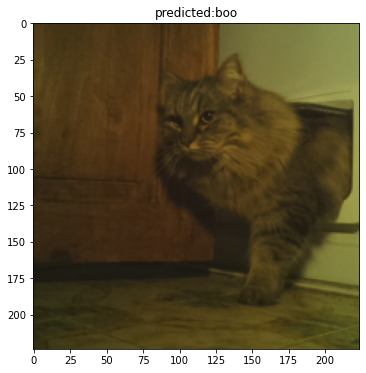

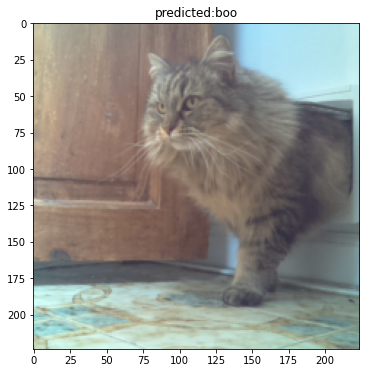

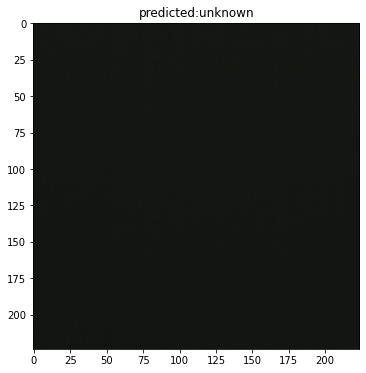

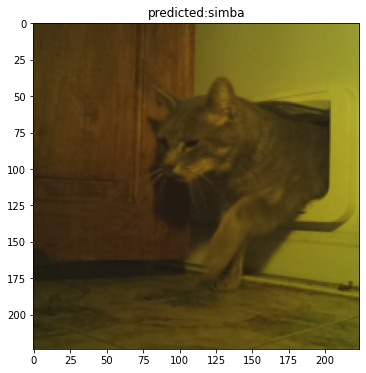

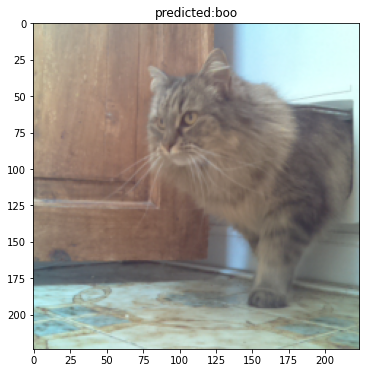

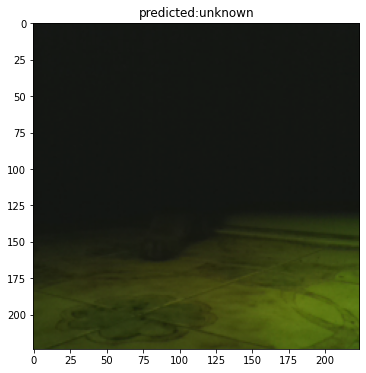

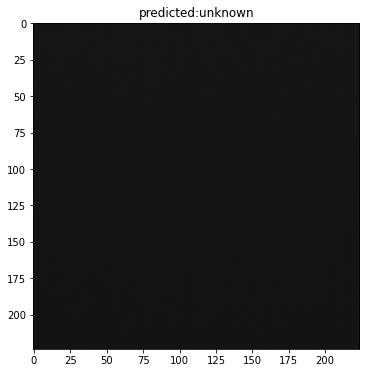

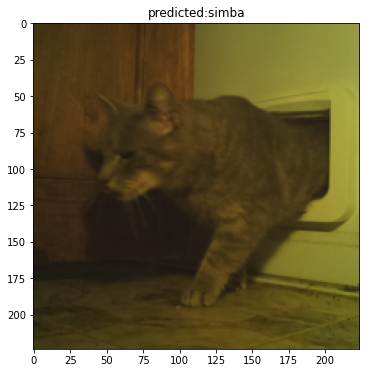

In [72]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])

Add probability

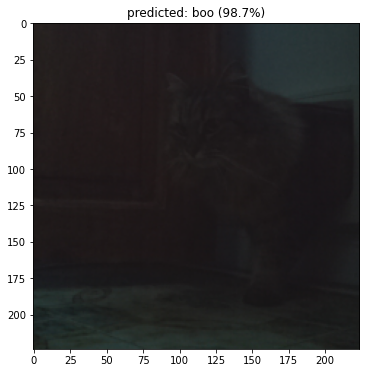

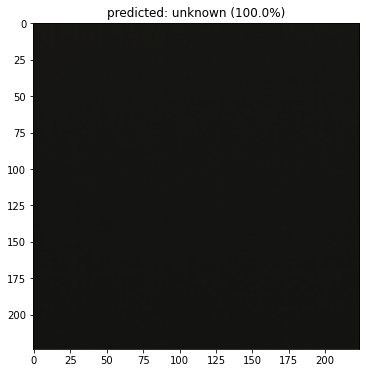

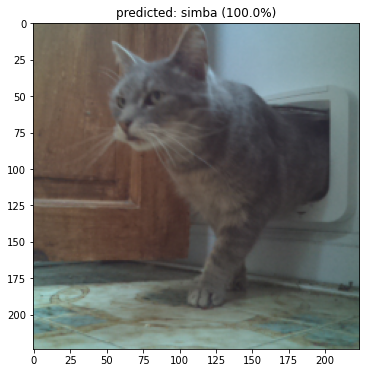

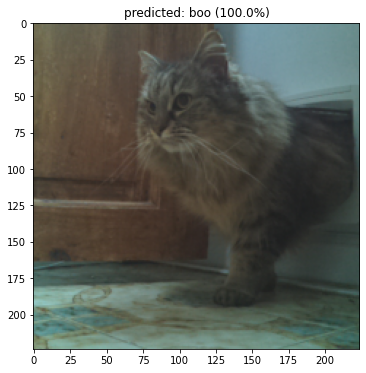

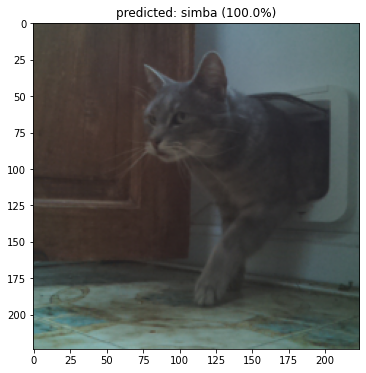

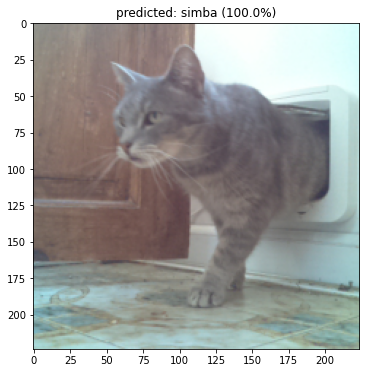

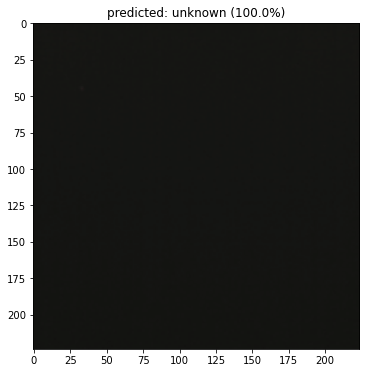

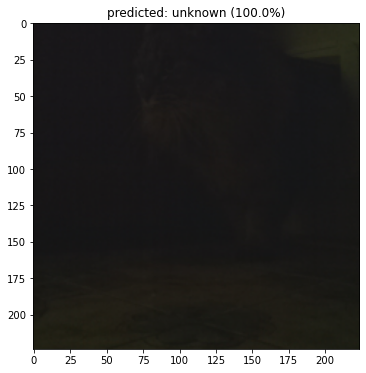

In [73]:
# https://discuss.pytorch.org/t/how-to-extract-probabilities/2720/15
sm = torch.nn.Softmax(dim=1)

with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    probs, preds = torch.max(outputs, 1)
    
    # calculate probabilities using softmax 
    probabilities = sm(outputs) 

    for j in range(len(inputs)):
        inp = inputs.data[j]
        
        label = class_names[preds[j]]        
        probability = probabilities[j][preds[j]]
        
        imshow(inp, f"predicted: {class_names[preds[j]]} ({probability:.1%})")

## Save trained model state dict

In [2]:
VGG16_MODEL_SD = "models/catmon-img-classifier_vgg16_state_dict_0.1"

In [ ]:
torch.save(model.state_dict(), VGG16_MODEL_SD)

## Prepare new model and load the saved model params from state dict

In [64]:
# Instantiate the model
new_model = models.vgg16(pretrained=True)

# TD: extract number of input and output features from the model
num_ftrs = new_model.classifier[6].in_features

# TD: Now change last linear layer of the model
# - change number of output categories to 3 (corresponding to our 3 catagories)
# - note that number of input features is unchanged (at 4096)

new_model.classifier[6] = nn.Linear(num_ftrs, 3)

In [65]:
new_model.load_state_dict(torch.load(VGG16_MODEL_SD))

<All keys matched successfully>

## Test accuracy of new model on unseen data 

In [69]:
%%time
# Switch to eval mode and make precictions using test data
new_model.eval() 

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        #TD: show more granular progress per batch
        print('.', end='')
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('\nAccuracy of the new model on the test images: {}%'\
          .format(100 * correct / total))

........................
Accuracy of the new model on the test images: 100.0%
Wall time: 55.1 s


## Use new model for prediction using test images

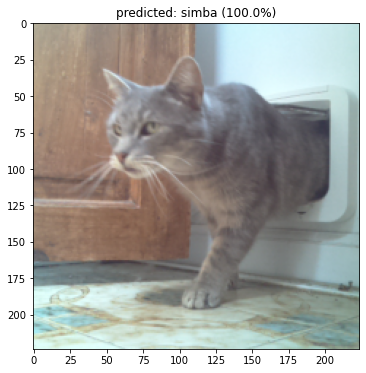

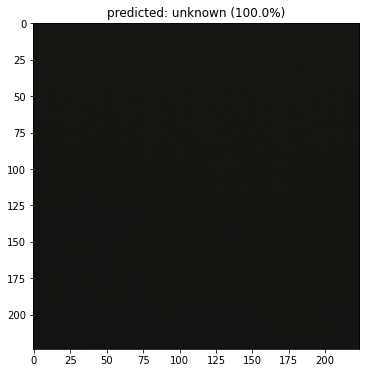

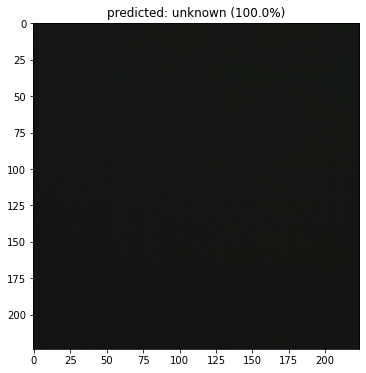

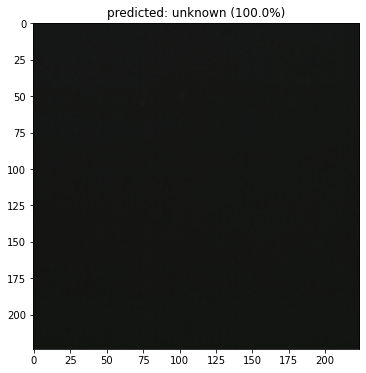

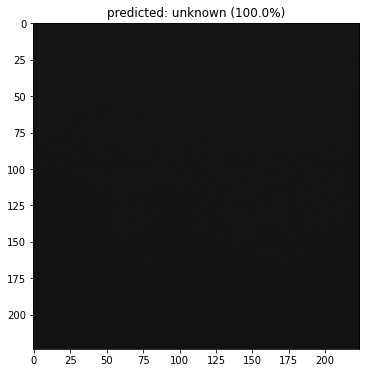

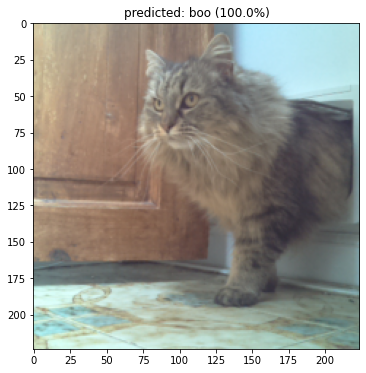

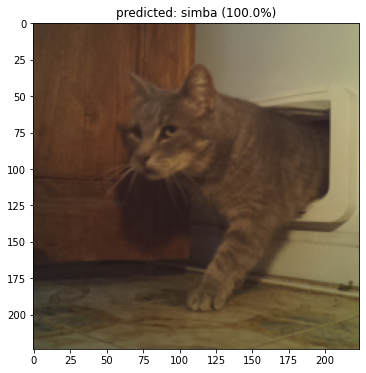

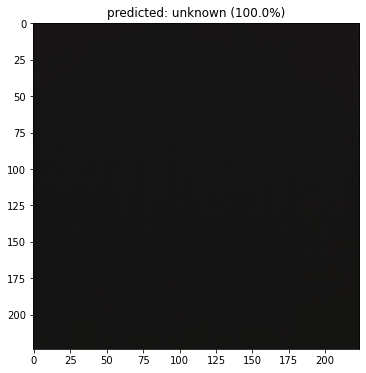

In [70]:
# https://discuss.pytorch.org/t/how-to-extract-probabilities/2720/15
sm = torch.nn.Softmax(dim=1)

with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = new_model(inputs)
    probs, preds = torch.max(outputs, 1)
    
    # calculate probabilities using softmax 
    probabilities = sm(outputs) 

    for j in range(len(inputs)):
        inp = inputs.data[j]
        
        label = class_names[preds[j]]        
        probability = probabilities[j][preds[j]]
        
        imshow(inp, f"predicted: {class_names[preds[j]]} ({probability:.1%})")

## Use new model for prediction with new catmon images

In [71]:
BOO_IMAGE = "images/new_boo_image_2022-06-22_084526.jpg"
SIMBA_IMAGE = "images/new_simba_image_2022-06-22_081417.jpg"

In [72]:
# Transform boo image

# first convert jpg to pil
boo_pil_img = Image.open(BOO_IMAGE)

# apply transform to create the required tensor
tensor = test_transform(boo_pil_img)
tensor.shape

torch.Size([3, 224, 224])

In [73]:
# reshape tensor to add dummy batch
reshaped_tensor = tensor.unsqueeze(0)
reshaped_tensor.shape

torch.Size([1, 3, 224, 224])

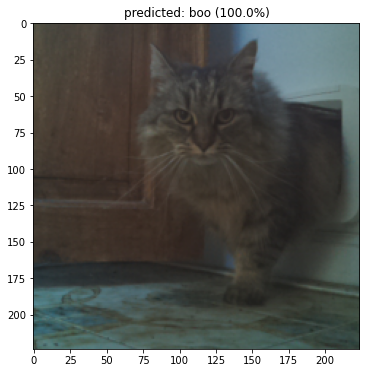

In [100]:
# classify the image
with torch.no_grad():
    
    inputs = reshaped_tensor.to(device)
    outputs = new_model(inputs)
    probs, preds = torch.max(outputs, 1)
    
    # calculate probabilities using softmax 
    probabilities = sm(outputs) 

    label = class_names[preds]
    probability = float(probabilities.flatten()[preds])
    
    img = inputs.data[0]
#     imshow(img, "title")

    imshow(img, f"predicted: {label} ({probability:.1%})")

In [75]:
def predict_catmon_image(model, jpg_image, display=True):
    """Return predicted label and probability for given model and jpg image.
    
    If display is True,
    Display image with predicted label and probability percentage, 
    
    """
    
    # convert jpg image to pil
    pil_img = Image.open(jpg_image)

    # apply transform to create the required tensor
    tensor = test_transform(pil_img)
    print(tensor.shape)
    
    # reshape tensor to add dummy batch
    reshaped_tensor = tensor.unsqueeze(0)
    print(reshaped_tensor.shape)
    
    # classify the image
    with torch.no_grad():

        inputs = reshaped_tensor.to(device)
        outputs = model(inputs)
        probs, preds = torch.max(outputs, 1)

        # calculate probabilities using softmax 
        probabilities = sm(outputs) 
        
        label = class_names[preds]
        probability = float(probabilities.flatten()[preds])

        print(probs, preds, probabilities)
        img = inputs.data[0]

    if display:
        imshow(img, f"predicted: {label} ({probability:.1%})")
    
    return label, probability

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([29.2612]) tensor([0]) tensor([[1.0000e+00, 1.4125e-12, 8.4753e-27]])


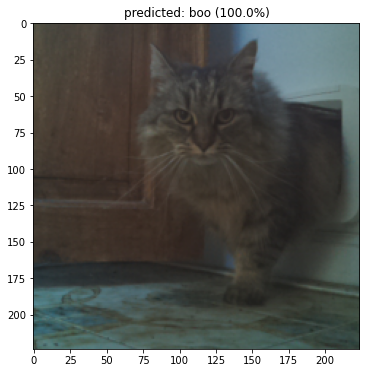

Wall time: 5.39 s


('boo', 1.0)

In [76]:
%%time
predict_catmon_image(new_model, BOO_IMAGE)

In [77]:
%%time
predict_catmon_image(new_model, BOO_IMAGE, display=False)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([29.2612]) tensor([0]) tensor([[1.0000e+00, 1.4125e-12, 8.4753e-27]])
Wall time: 302 ms


('boo', 1.0)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([18.2657]) tensor([1]) tensor([[5.1744e-10, 1.0000e+00, 2.3808e-15]])


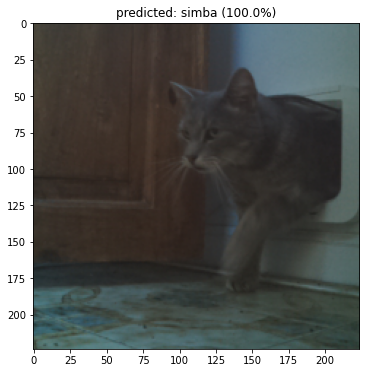

('simba', 1.0)

In [78]:
predict_catmon_image(new_model, SIMBA_IMAGE)

In [79]:
predict_catmon_image(new_model, SIMBA_IMAGE, display=False)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([18.2657]) tensor([1]) tensor([[5.1744e-10, 1.0000e+00, 2.3808e-15]])


('simba', 1.0)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([15.2388]) tensor([2]) tensor([[1.5290e-09, 1.0855e-11, 1.0000e+00]])


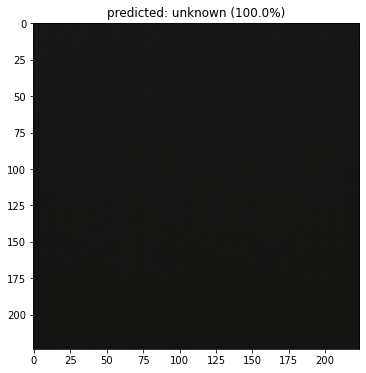

('unknown', 1.0)

In [80]:
UNKNOWN_IMAGE = "images/new_unknown_image_2022-06-22_224320.jpg"
predict_catmon_image(new_model, UNKNOWN_IMAGE, display=True)

## Use new model for prediction with new random images

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([7.4930]) tensor([2]) tensor([[4.8142e-05, 4.1186e-06, 9.9995e-01]])


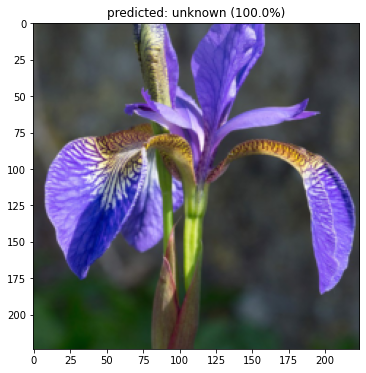

('unknown', 0.9999477863311768)

In [94]:
RANDOM_IMAGE1 = "images/Iris_germanica_(Purple_bearded_Iris)_Wikipedia.jpg"
predict_catmon_image(new_model, RANDOM_IMAGE1, display=True)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([5.5787]) tensor([2]) tensor([[2.4452e-03, 1.3937e-05, 9.9754e-01]])


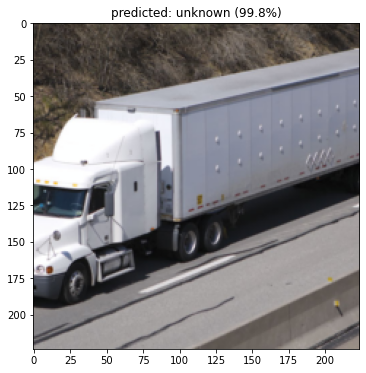

('unknown', 0.9975408315658569)

In [95]:
RANDOM_IMAGE2 = "images/semi-semitrailer-truck-tractor-highway.jpg"
predict_catmon_image(new_model, RANDOM_IMAGE2, display=True)

## Use new model for prediction with new non-catmon images of boo and simba

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([19.2097]) tensor([0]) tensor([[1.0000e+00, 5.1780e-11, 6.0581e-15]])


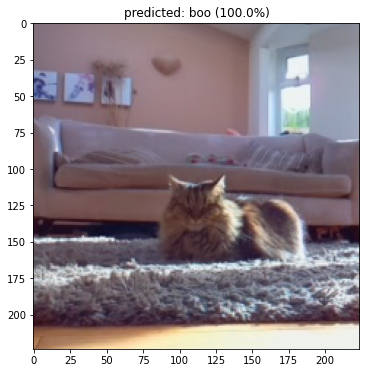

('boo', 1.0)

In [92]:
BOO_NON_CATMON_IMAGE = "images/boo_not_catmon_image.jpg"
predict_catmon_image(new_model, BOO_NON_CATMON_IMAGE, display=True)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([4.8727]) tensor([0]) tensor([[6.7622e-01, 3.2378e-01, 1.1777e-06]])


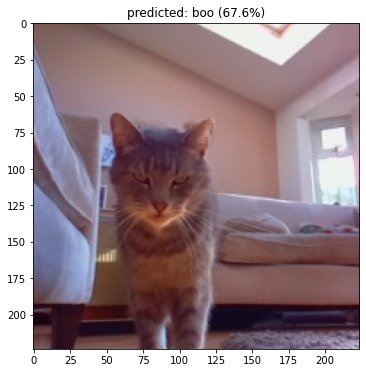

('boo', 0.6762166619300842)

In [93]:
SIMBA_NON_CATMON_IMAGE = "images/simba_not_catmon_image.jpg"
predict_catmon_image(new_model, SIMBA_NON_CATMON_IMAGE, display=True)